In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import os
from glob import glob

if not os.path.exists('../paper/figs'):
    os.makedirs('../paper/figs')

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample(3)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierBottomUp.py', '../models/SimplifierTopDown1e-0.py', '../models/SimplifierTopDown1e-4.py', '../models/SimplifierTopDown.py', '../models/Vanilla.py', '../models/SimplifierTopDown1e-2.py', '../models/SimplifierTopDown1e-1.py'] ['Simplifier Bottom Up', 'Simplifier Top Down 1e-0', 'Simplifier Top Down 1e-4', 'Simplifier Top Down', 'Without simplification', 'Simplifier Top Down 1e-2', 'Simplifier Top Down 1e-1']
(1260, 14)
['Simplifier Bottom Up' 'Simplifier Top Down 1e-0'
 'Simplifier Top Down 1e-4' 'Simplifier Top Down' 'Without simplification'
 'Simplifier Top Down 1e-2' 'Simplifier Top Down 1e-1']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing' 'Yacht']
range(10, 250, 25)


,model,dataset,delta
0,Simplifier Bottom Up,Airfoil,34.782609
1,Simplifier Bottom Up,Airfoil,-5.000000
2,Simplifier Bottom Up,Airfoil,-76.470588
3,Simplifier Bottom Up,Airfoil,21.739130
4,Simplifier Bottom Up,Airfoil,-5.555556
...,...,...,...
1255,Without simplification,Yacht,0.000000
1256,Without simplification,Yacht,0.000000
1257,Without simplification,Yacht,0.000000
1258,Without simplification,Yacht,0.000000


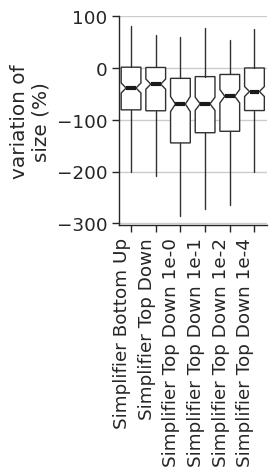

In [16]:
baseline_convergence = (results_df.loc[results_df['model'] == 'Without simplification'].groupby(['dataset', 'random_state']))

metric = 'size'
speeds    = []
for (model, dataset, random_state), group_df in \
    results_df.loc[results_df['model'] != 'Baseline'].groupby(['model', 'dataset', 'random_state']):
    # 'contextual' is used as a hue in the plots

    baseline_curve = baseline_convergence.get_group((dataset, random_state))
    
    metric_baseline = baseline_curve[metric].values[0]
    metric_model = group_df[metric].values[0]
    speeds.append( (model, dataset, (metric_model-metric_baseline)*100/metric_model) )

speeds_df = pd.DataFrame(data=speeds, columns=['model', 'dataset', 'delta'])
display(speeds_df)
g=sns.catplot( data=speeds_df, y=f'delta', x='model', 
    #col='dataset', col_wrap=col_wrap, # remove col to aggregate all speed ups into one plot
    legend_out=False, aspect=0.6,
    order = [o for o in order if o != 'Without simplification'], # The first is Baseline
    **boxplot_kwargs, sharey=False
)

# g.set(yscale="log")

g.set_titles("{col_name}").set_axis_labels("", f"variation of\n{metric} (%)")

# iterate through each subplot / Facet
single_plot = True
for (ds, plot_ax) in g._axes_dict.items():
    single_plot = False
    plot_ax.grid(which='major', axis='y', linewidth=1)
    #plot_ax.axhline(100.0, c='k', zorder=-999, linewidth=1.5)
    
    for tick in plot_ax.get_xticklabels():
        tick.set(rotation=90, ha="right")

    # Contextual vs non-contextual
    pairs = [('D-TS', 'C-D-TS'), ('D-UCB1', 'C-D-UCB1')]

    if False:
        annotator = Annotator(
            plot_ax, pairs, data=speeds_df[(speeds_df['dataset']==ds)],
            x='model', y='Speed up',
            order=order[1:])
        annotator.reset_configuration()
        annotator.configure(test="Mann-Whitney", hide_non_significant=True, #text_format='full',
                            comparisons_correction="holm", verbose=1, text_offset=-3)
        
        # Calculate and annotate
        annotator.apply_and_annotate()
        
if single_plot: 
    g.ax.grid(which='major', axis='y', linewidth=1)
    #g.ax.axhline(1.0, c='k', zorder=-999, linewidth=1.5)
    
    for tick in g.ax.get_xticklabels():
        tick.set(rotation=90, ha="right")

plt.tight_layout()
plt.savefig(f"../paper/figs/delta_{metric}.pdf")
plt.savefig(f"../paper/figs/delta_{metric}.png")
plt.show()